In [1]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

from src.model import Discriminator, Generator, weights_init_normal

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))



In [27]:
batch_size = 1
dataroot = '../datasets/summer2winter_yosemite/'
size = 256
input_nc = 3
output_nc = 3
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

#Generator
netG_sum2win = Generator(input_nc, output_nc).to(device)
netG_win2sum = Generator(output_nc, input_nc).to(device)
# Discriminator
netD_sum = Discriminator(input_nc).to(device)
netD_win = Discriminator(output_nc).to(device)

netG_sum2win.load_state_dict(torch.load("checkpoints/CycleGAN_netG_sum2win.pth"))
netG_win2sum.load_state_dict(torch.load("checkpoints/CycleGAN_netG_win2sum.pth"))
netD_win.load_state_dict(torch.load("checkpoints/CycleGAN_netD_win.pth"))
netD_sum.load_state_dict(torch.load("checkpoints/CycleGAN_netD_sum.pth"))

#data loader
transforms_ = [ transforms.CenterCrop(size), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
test_dl = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True, mode='test'), 
                        batch_size=batch_size, shuffle=False, num_workers=4)

In [28]:
def image_normalized(img):
    mean,std=[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    img = img.squeeze().cpu().detach().numpy()
    img = img.squeeze().transpose(1,2,0)
    img = img*np.array(std) + np.array(mean)
    return img

tmp = test_dl.__iter__()

Text(0.5, 0, 'reconsist summer')

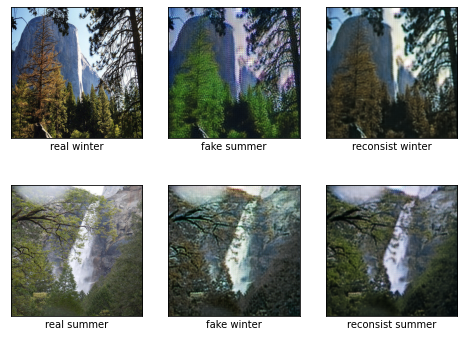

In [34]:
real = tmp.next()
real_win = real['B'].to(device)
fake_sum = netG_win2sum(real_win)
recovered_win = netG_sum2win(fake_sum)
real_sum = real['A'].to(device)
fake_win = netG_sum2win(real_sum)
recovered_sum = netG_win2sum(fake_win)

fig = plt.figure(figsize=(8.0, 6.0))
real_win = image_normalized(real_win)
fake_sum = image_normalized(fake_sum)
recovered_win = image_normalized(recovered_win)
real_sum = image_normalized(real_sum)
fake_win = image_normalized(fake_win)
recovered_sum = image_normalized(recovered_sum)
ax = fig.add_subplot(2,3,1,xticks=[], yticks=[])
ax.imshow(real_win)
ax.set_xlabel("real winter")
ax = fig.add_subplot(2,3,2,xticks=[], yticks=[])
ax.imshow(fake_sum)
ax.set_xlabel("fake summer")
ax = fig.add_subplot(2,3,3,xticks=[], yticks=[])
ax.imshow(recovered_win)
ax.set_xlabel("reconsist winter")
ax = fig.add_subplot(2,3,4,xticks=[], yticks=[])
ax.imshow(real_sum)
ax.set_xlabel("real summer")
ax = fig.add_subplot(2,3,5,xticks=[], yticks=[])
ax.imshow(fake_win)
ax.set_xlabel("fake winter")
ax = fig.add_subplot(2,3,6,xticks=[], yticks=[])
ax.imshow(recovered_sum)
ax.set_xlabel("reconsist summer")